# CNN models trained for the automated diagnosis of COVID-19

In this notebook I will train many Convolutional Neural Networks to compare and contrast the effects of the data augmentation achieved through the use of multiple Generative Adversarial Networks.  I will also show the data we will be using to train such models and examples of the "fake" data generated through the use of GANs.

In [50]:
from google.colab import drive
drive.mount('/content/gdrive')
!ls "/content/gdrive/My Drive/COVID-19_Radiography_Dataset"

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
 COVID			      Normal.metadata.xlsx
 COVID.metadata.xlsx	      README.md.txt
 Lung_Opacity.metadata.xlsx  'Viral Pneumonia'
 Normal			     'Viral Pneumonia.metadata.xlsx'


In [51]:
# import packages

import tensorflow as tf
from keras import datasets, layers, models
import keras as keras
import numpy as np
import pandas as pd
import matplotlib as plt
import os
import graphviz
from keras.utils.vis_utils import plot_model
from keras_preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt


# for reproducibility - ref https://machinelearningmastery.com/reproducible-results-neural-networks-keras/ and https://www.tensorflow.org/api_docs/python/tf/keras/utils/set_random_seed
np.random.seed(9)
tf.keras.utils.set_random_seed(10)

chest_xray_dataset = os.path.abspath("/content/gdrive/My Drive/COVID 19 CHEST XRAY/images")
chest_xray_dataset_annotations = os.path.abspath("/content/gdrive/My Drive/COVID 19 CHEST XRAY/metadata.csv")
radiography_dataset = os.path.abspath("/content/gdrive/My Drive/COVID-19_Radiography_Dataset/")
xray_covid19_dataset = os.path.abspath("/content/gdrive/My Drive/xray_dataset_covid19/")


## Listing the files in each datasets directory

As we can see below there are numerous files for each type of category which we will be looking to predict from the patients X-Ray


In [52]:
print(os.listdir(chest_xray_dataset))

['covid-19-infection-exclusive-gastrointestinal-symptoms-l.png', '16691_1_1.jpg', '88de9d8c39e946abd495b37cd07d89e5-0666-0.jpg', '1-s2.0-S0929664620300449-gr2_lrg-c.jpg', 'SARS-10.1148rg.242035193-g04mr34g04a-Fig4a-day7.jpeg', '1312A392-67A3-4EBF-9319-810CF6DA5EF6.jpeg', 'auntminnie-c-2020_01_28_23_51_6665_2020_01_28_Vietnam_coronavirus.jpeg', 'case_71_figura1.png', 'DE488FE1-0C44-428B-B67A-09741C1214C0.jpeg', '16669_3_1.jpeg', '5083A6B7-8983-472E-A427-570A3E03DDEE.jpeg', 'cavitating-pneumonia-4-day0-PA.jpg', '16706_1_1.png', 'ciaa199.pdf-001-c.png', '2C26F453-AF3B-4517-BB9E-802CF2179543.jpeg', 'covid-19-caso-70-1-L.jpg', 'acute-respiratory-distress-syndrome-ards.jpg', '66298CBF-6F10-42D5-A688-741F6AC84A76.jpeg', '1-s2.0-S1684118220300682-main.pdf-003-b1.png', '88de9d8c39e946abd495b37cd07d89e5-6531-0.jpg', 'B2D20576-00B7-4519-A415-72DE29C90C34.jpeg', '9C34AF49-E589-44D5-92D3-168B3B04E4A6.jpeg', '1-s2.0-S0929664620300449-gr2_lrg-b.jpg', 'aspiration-pneumonia-5-day10.jpg', 'aspiration-pn

In [53]:
print(os.listdir(radiography_dataset))

['COVID.metadata.xlsx', 'Lung_Opacity.metadata.xlsx', 'Normal.metadata.xlsx', 'Viral Pneumonia.metadata.xlsx', 'README.md.txt', 'COVID', 'Viral Pneumonia', 'Normal']


In [54]:
print(os.listdir(xray_covid19_dataset))

['test', 'train']


## Examples of Classes from each dataset and setting train / validation sets

Found 188 files belonging to 2 classes.
Using 132 files for training.
Found 188 files belonging to 2 classes.
Using 56 files for validation.
class_names: ['test', 'train']


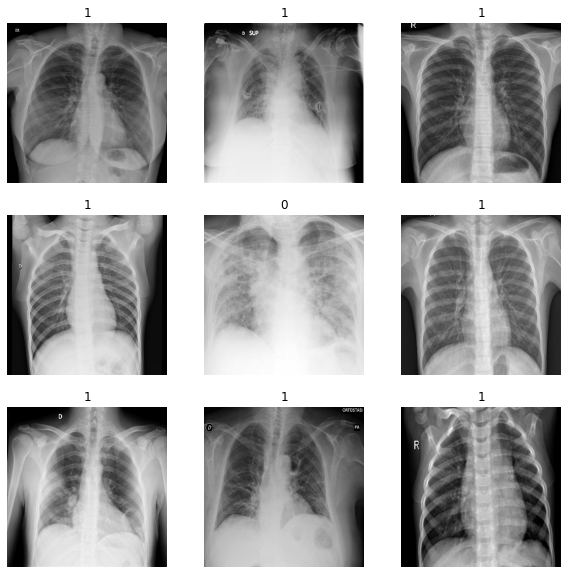

In [55]:
#Loading of images based on ref: https://keras.io/examples/vision/image_classification_from_scratch/ 

image_size = (299, 299)
batch_size = 16
train_ds = tf.keras.utils.image_dataset_from_directory(xray_covid19_dataset, validation_split=0.3,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
    shuffle='true'
)

val_ds = tf.keras.utils.image_dataset_from_directory(xray_covid19_dataset, validation_split=0.3,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
    shuffle='true'
)
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")
class_names = val_ds.class_names
print( "class_names: " + str( class_names ) )


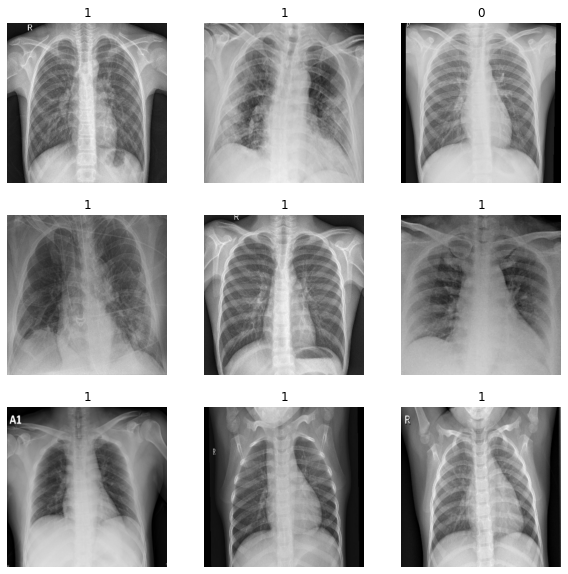

In [56]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [57]:
!pip install pydot
!pip install graphviz 


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


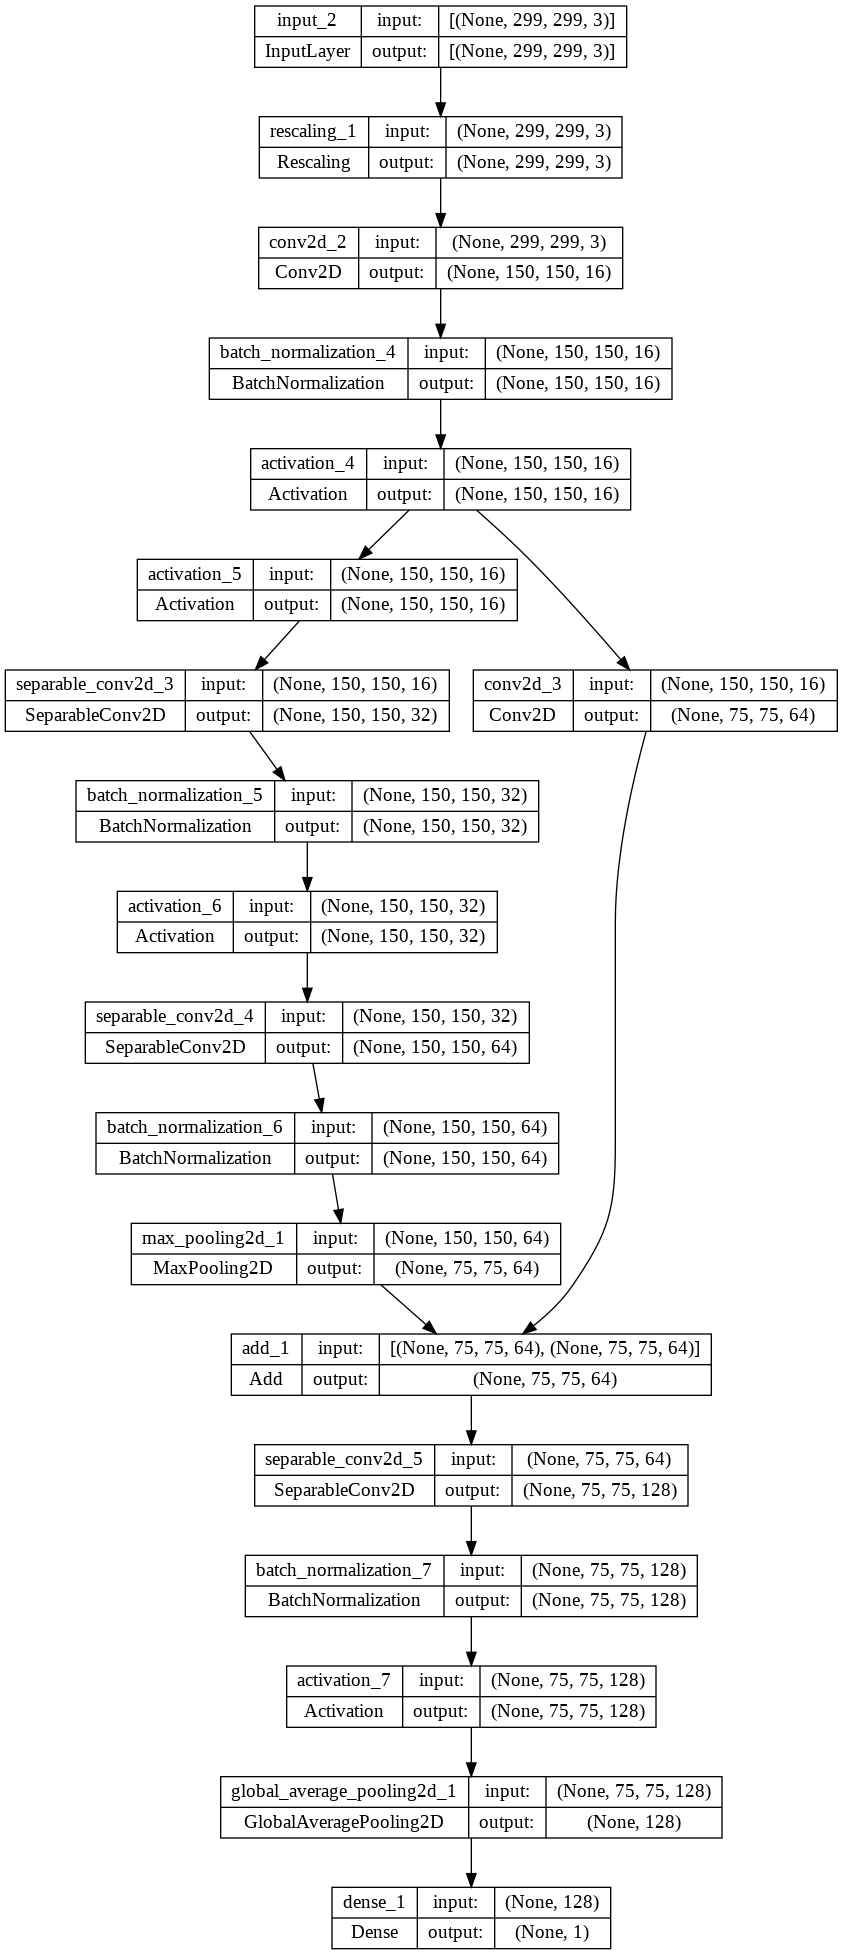

In [58]:
#CNN Model based on ref: https://keras.io/examples/vision/image_classification_from_scratch/ 
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(16, (3,3), strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("swish")(x)

    previous_block_activation = x  # Set aside residual

    x = layers.Activation("swish")(x)
    x = layers.SeparableConv2D(32, (3,3), padding="same")(x)
    x = layers.BatchNormalization()(x)
    
    x = layers.Activation("swish")(x)
    x = layers.SeparableConv2D(64, (3,3), padding="same")(x)
    x = layers.BatchNormalization()(x)
    
    
    x = layers.MaxPooling2D(2, strides=2, padding="same")(x)

    # Project residual
    residual = layers.Conv2D(64, (3,3), strides=2, padding="same")(
          previous_block_activation
      ) 
    x = layers.add([x, residual])  # Add back residual
    previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(128, (3,3), padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("swish")(x)

    x = layers.GlobalAveragePooling2D()(x)
    activation = "sigmoid"
    units = 1

    outputs = layers.Dense(1, activation=activation)(x)
    return keras.Model(inputs, outputs)
model = make_model(input_shape=(image_size) + (3,), num_classes=1)
keras.utils.plot_model(model, show_shapes=True)


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_1 (Rescaling)        (None, 299, 299, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv2d_2 (Conv2D)              (None, 150, 150, 16  448         ['rescaling_1[0][0]']            
                                )                                                                 
                                                                                            

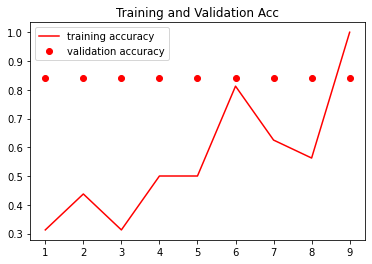

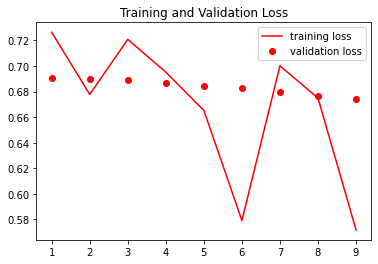

In [59]:
epochs = 9

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["binary_accuracy"],
)
model.summary()
history = model.fit(
    train_ds,
    epochs=epochs,
    steps_per_epoch=1,
    callbacks=callbacks,
    validation_data=val_ds)
model.evaluate(val_ds)
model.save('content/gdrive/My Drive/CNN_Models_Baseline/xray_covid19_dataset_model.h5')
print(history.history.keys())
accuracy = history.history['binary_accuracy']
val_accuracy = history.history['val_binary_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1,len(accuracy) + 1)

plt.plot(epochs, accuracy,'r',label = 'training accuracy')
plt.plot(epochs, val_accuracy,'ro',label = 'validation accuracy')
plt.title('Training and Validation Acc')
plt.legend()
plt.show()

plt.plot(epochs, train_loss,'r',label = 'training loss')
plt.plot(epochs, val_loss,'ro',label = 'validation loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

Found 30306 files belonging to 3 classes.
Using 29700 files for training.
Found 30306 files belonging to 3 classes.
Using 606 files for validation.
class_names: ['COVID', 'Normal', 'Viral Pneumonia']


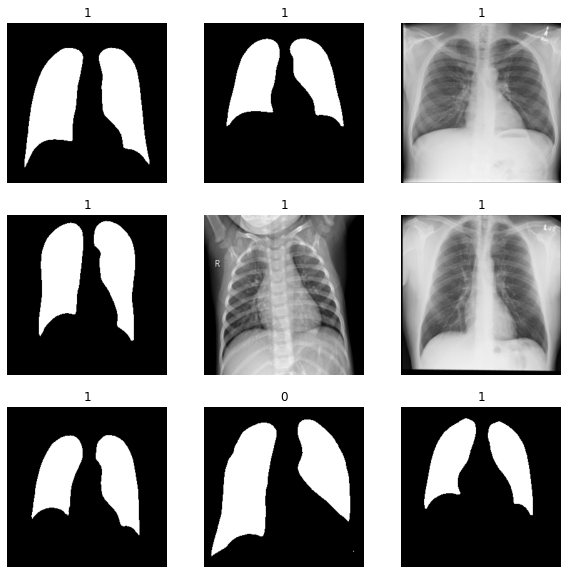

In [60]:
#Loading of images based on ref: https://keras.io/examples/vision/image_classification_from_scratch/ 

image_size = (256, 256)
batch_size = 32
train_ds = tf.keras.utils.image_dataset_from_directory(radiography_dataset, validation_split=0.02,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

val_ds = tf.keras.utils.image_dataset_from_directory(radiography_dataset, validation_split=0.02,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")
class_names = val_ds.class_names
print( "class_names: " + str( class_names ) )

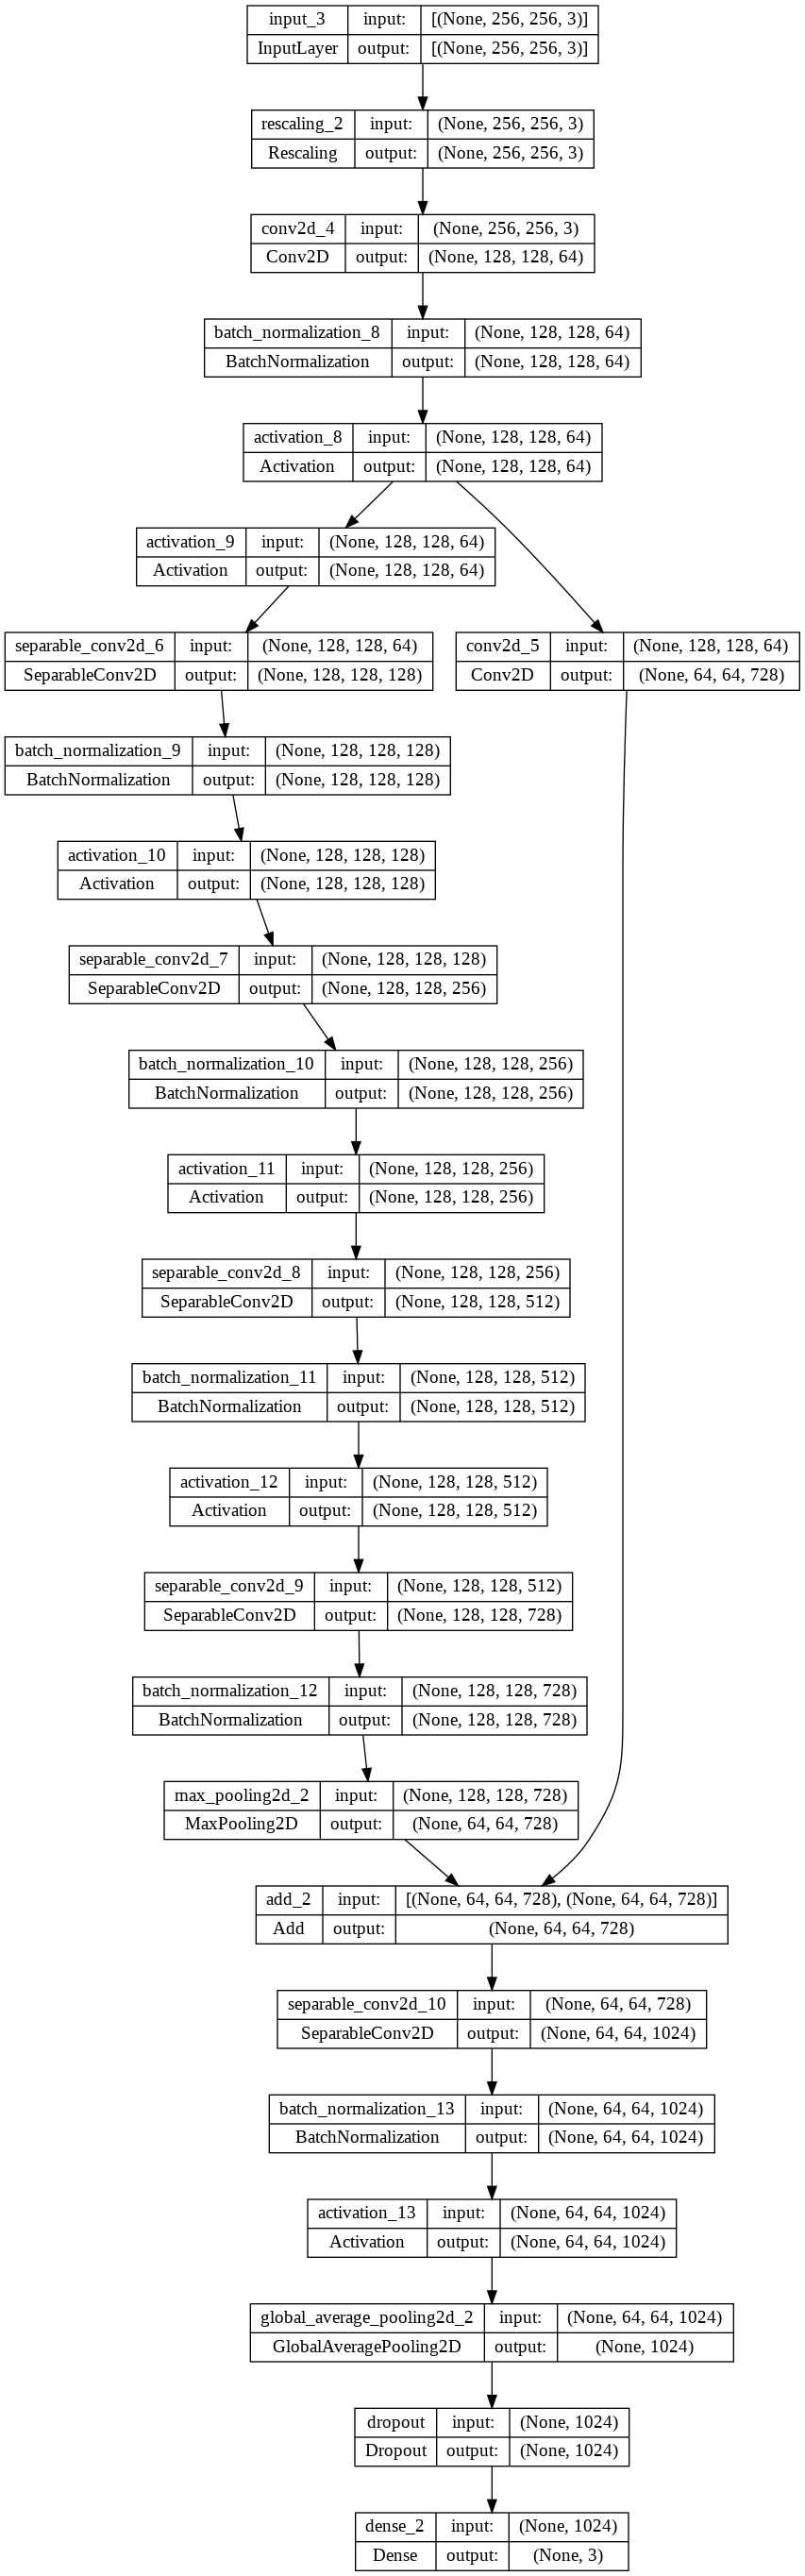

In [61]:
#CNN Model based on ref: https://keras.io/examples/vision/image_classification_from_scratch/ 


def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(64, (3,3), strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    x = layers.Activation("relu")(x)
    x = layers.SeparableConv2D(128, (3,3), padding="same")(x)
    x = layers.BatchNormalization()(x)
    
    x = layers.Activation("relu")(x)
    x = layers.SeparableConv2D(256, (3,3), padding="same")(x)
    x = layers.BatchNormalization()(x)

    x = layers.Activation("relu")(x)
    x = layers.SeparableConv2D(512, (3,3), padding="same")(x)
    x = layers.BatchNormalization()(x)

    x = layers.Activation("relu")(x)
    x = layers.SeparableConv2D(728, (3,3), padding="same")(x)
    x = layers.BatchNormalization()(x)

    x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

    # Project residual
    residual = layers.Conv2D(728, (3,3), strides=2, padding="same")(
          previous_block_activation
      ) 
    x = layers.add([x, residual])  # Add back residual
    previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, (3,3), padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    activation = "softmax"
    units = 3

    x = layers.Dropout(0)(x)
    outputs = layers.Dense(3, activation=activation)(x)
    return keras.Model(inputs, outputs)
model = make_model(input_shape=(image_size) + (3,), num_classes=3)
keras.utils.plot_model(model, show_shapes=True)


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_2 (Rescaling)        (None, 256, 256, 3)  0           ['input_3[0][0]']                
                                                                                                  
 conv2d_4 (Conv2D)              (None, 128, 128, 64  1792        ['rescaling_2[0][0]']            
                                )                                                                 
                                                                                            

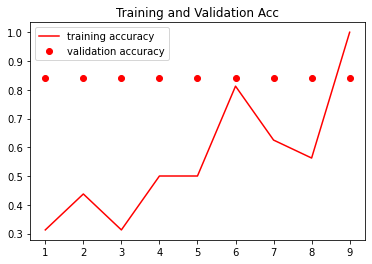

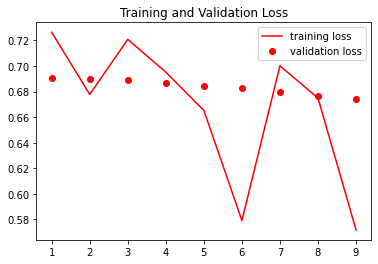

In [69]:
epochs = 44

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["acc"],
) 
model.summary()
model.fit(
    train_ds,
    epochs=epochs,
    steps_per_epoch=18,
    callbacks=callbacks,
    validation_data=val_ds)
model.save('content/gdrive/My Drive/CNN_Models_Baseline/radiography_model.h5')

print(history.history.keys())

accuracy = history.history['binary_accuracy']
val_accuracy = history.history['val_binary_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy,'r',label = 'training accuracy')
plt.plot(epochs, val_accuracy,'ro',label = 'validation accuracy')
plt.title('Training and Validation Acc')
plt.legend()
plt.show()

plt.plot(epochs, train_loss,'r',label = 'training loss')
plt.plot(epochs, val_loss,'ro',label = 'validation loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [70]:
imageDf = pd.read_csv(chest_xray_dataset_annotations)
print(imageDf.finding)

0      COVID-19
1      COVID-19
2      COVID-19
3      COVID-19
4      COVID-19
         ...   
367    COVID-19
368    COVID-19
369    COVID-19
370    COVID-19
371    COVID-19
Name: finding, Length: 372, dtype: object


In [71]:
# used following resource for ref https://stackoverflow.com/questions/42443936/keras-split-train-test-set-when-using-imagedatagenerator
# Decided to use target size of 1024, 1024 for padding as there isn't a consistent resolution

image_size = (1024, 1024)
batch_size = 10
datagen=ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator=datagen.flow_from_dataframe(dataframe=imageDf, directory=chest_xray_dataset, x_col="filename", y_col="finding", class_mode="categorical", target_size=(1024,1024), batch_size=16, subset='training')
validation_generator = datagen.flow_from_dataframe(dataframe=imageDf, directory=chest_xray_dataset, x_col="filename", y_col="finding", class_mode="categorical", target_size=(1024,1024), batch_size=16,subset='validation')
print('test',validation_generator)


Found 281 validated image filenames belonging to 11 classes.
Found 70 validated image filenames belonging to 11 classes.
test <keras_preprocessing.image.dataframe_iterator.DataFrameIterator object at 0x7f9194cc7b20>


/usr/local/lib/python3.8/dist-packages/keras_preprocessing/image/dataframe_iterator.py:279: UserWarning: Found 21 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  warnings.warn(


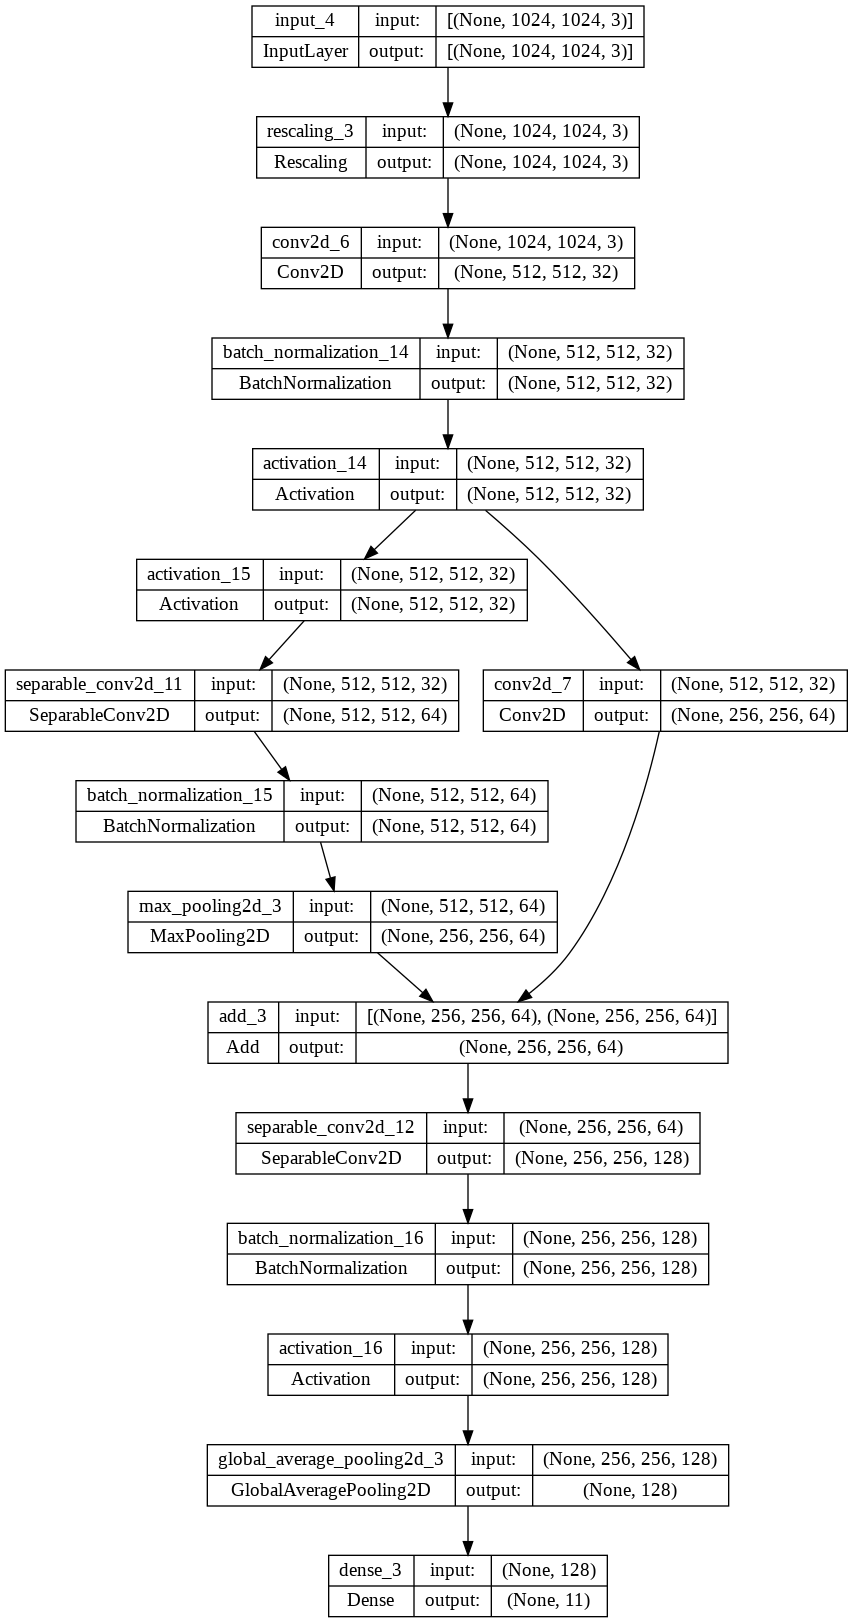

In [72]:
#CNN Model based on ref: https://keras.io/examples/vision/image_classification_from_scratch/ 

def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(32, (3,3), strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("swish")(x)

    previous_block_activation = x  # Set aside residual

    x = layers.Activation("swish")(x)
    x = layers.SeparableConv2D(64, (3,3), padding="same")(x)
    x = layers.BatchNormalization()(x)
    
    x = layers.MaxPooling2D(11, strides=2, padding="same")(x)

    # Project residual
    residual = layers.Conv2D(64, (3,3), strides=2, padding="same")(
          previous_block_activation
      ) 
    x = layers.add([x, residual])  # Add back residual
    previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(128, (3,3), padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("swish")(x)

    x = layers.GlobalAveragePooling2D()(x)
    activation = "softmax"
    units = 11

    outputs = layers.Dense(11, activation=activation)(x)
    return keras.Model(inputs, outputs)
model = make_model(input_shape=(image_size) + (3,), num_classes=11)
keras.utils.plot_model(model, show_shapes=True)


Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 1024, 1024,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling_3 (Rescaling)        (None, 1024, 1024,   0           ['input_4[0][0]']                
                                3)                                                                
                                                                                                  
 conv2d_6 (Conv2D)              (None, 512, 512, 32  896         ['rescaling_3[0][0]']            
                                )                                                           

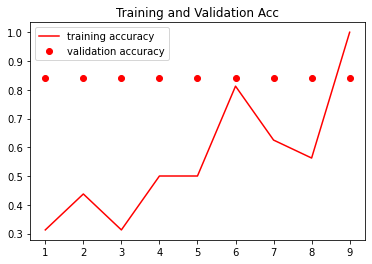

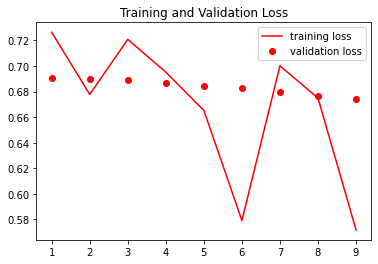

In [73]:
epochs = 10

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="categorical_crossentropy",
    metrics=["acc"],
) 
model.summary()
model.fit(
    train_generator,
    epochs=epochs,
    steps_per_epoch=1,
    callbacks=callbacks,
    validation_data=validation_generator)
model.save('content/gdrive/My Drive/CNN_Models_Baseline/chest_xray_dataset_model.h5')
print(history.history.keys())

accuracy = history.history['binary_accuracy']
val_accuracy = history.history['val_binary_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(accuracy) + 1)

plt.plot(epochs, accuracy,'r',label = 'training accuracy')
plt.plot(epochs, val_accuracy,'ro',label = 'validation accuracy')
plt.title('Training and Validation Acc')
plt.legend()
plt.show()

plt.plot(epochs, train_loss,'r',label = 'training loss')
plt.plot(epochs, val_loss,'ro',label = 'validation loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()